<a href="https://colab.research.google.com/github/sam2104/Multimodal-Emotion-Recognition/blob/master/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
<hr>

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

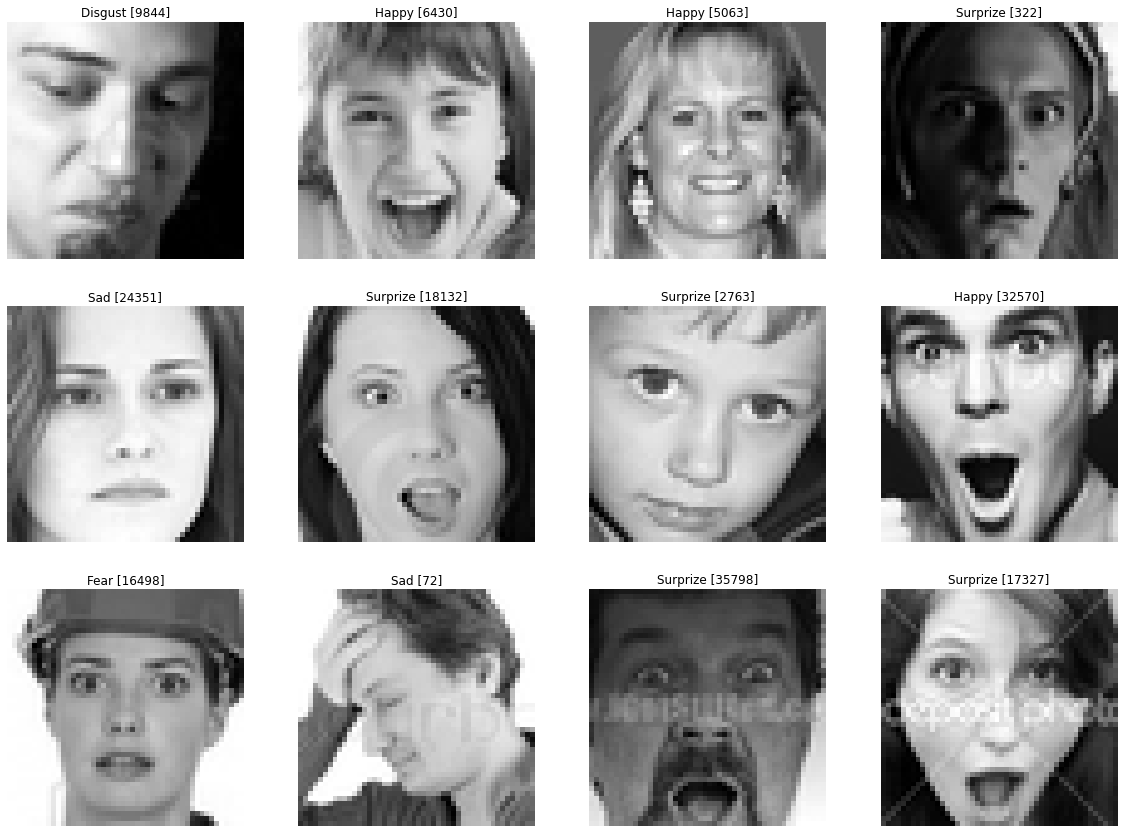

##Here we are also going to use OpenCV for the webcam and model deployement.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [3]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


**Put the name of the dataset that you want to use and then unzip the dataset**

In [4]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
100% 96.6M/96.6M [00:05<00:00, 23.6MB/s]
100% 96.6M/96.6M [00:05<00:00, 18.6MB/s]


In [5]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


#Importing necesaary files
<hr>



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [6]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

#Exploraotry Data Analysis
<hr>



In [7]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [8]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [9]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


##No of images present in dataset corresponding to training testing and validation part

In [10]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


##Visualizing images from the dataset

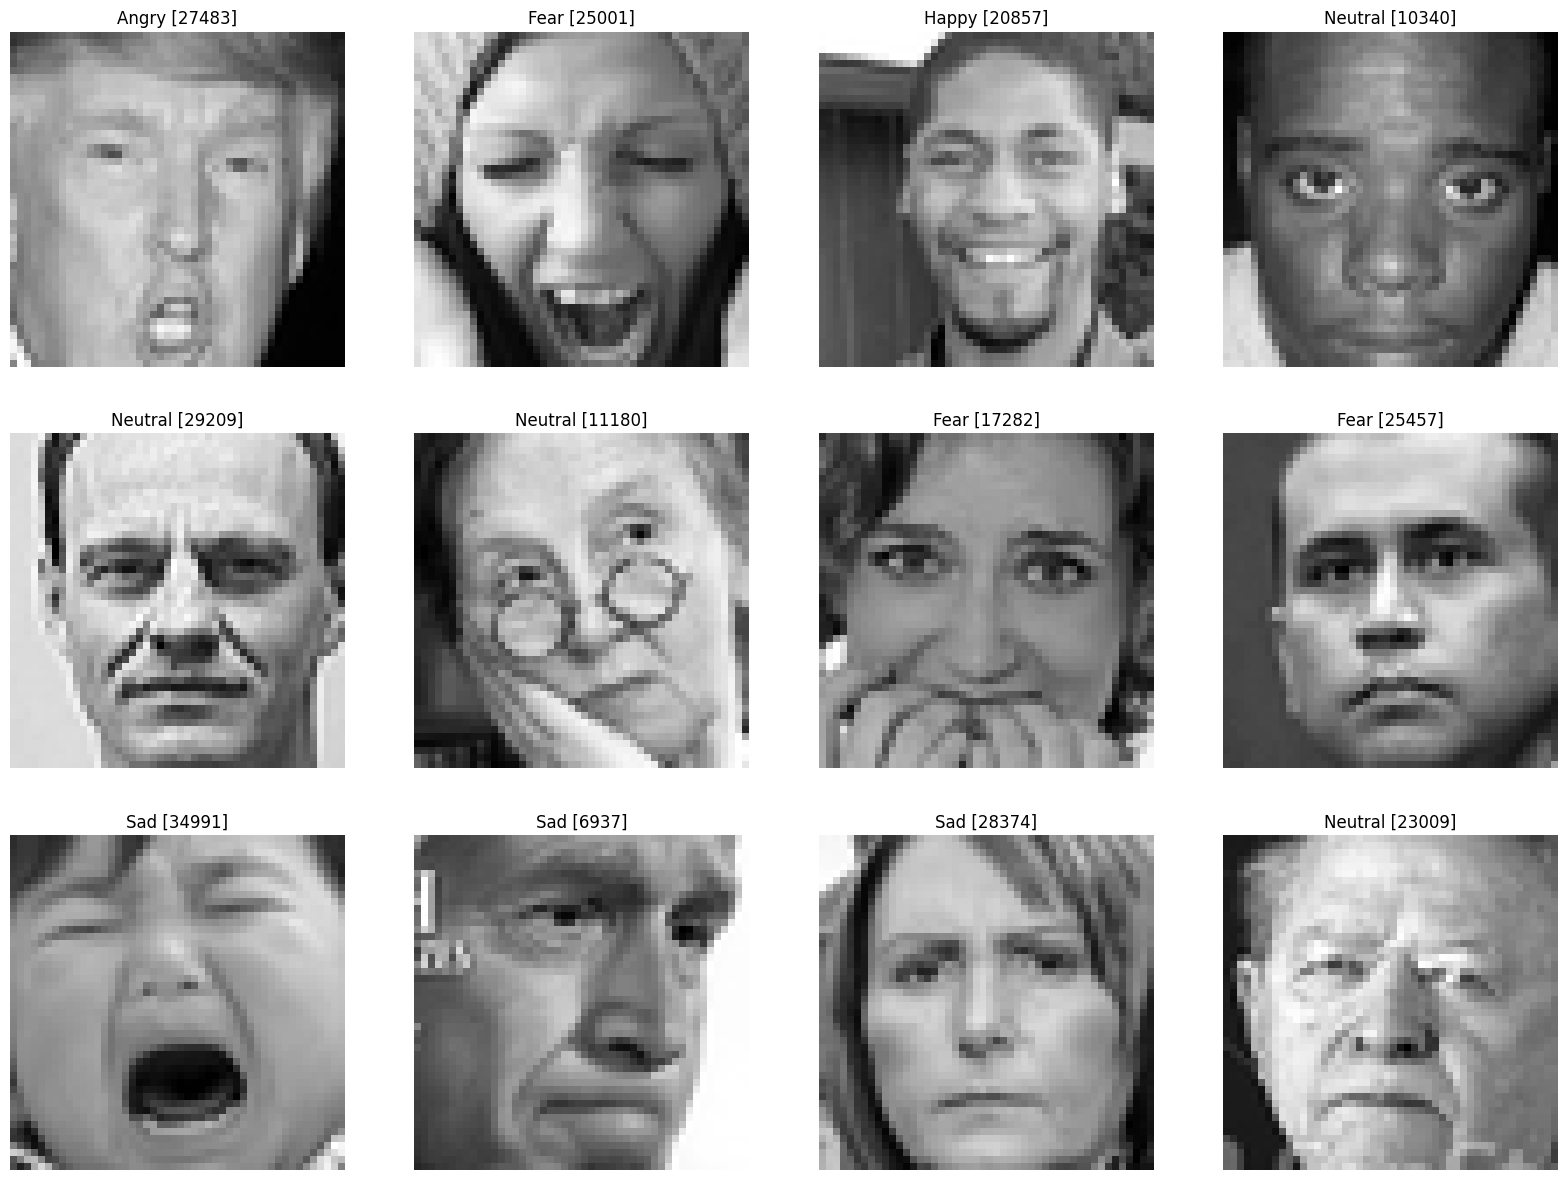

In [11]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [12]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [13]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

In [14]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

#Defining Model Archietechture

VGG16

In [15]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [16]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)          │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l1 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pad2 (ZeroPadding2D)          │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l2 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad1 (ZeroPadding2D)          │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l1 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l2 (ZeroPadding2D)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad2 (Conv2D)                 │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad1 (ZeroPadding2D)          │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l1 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad2 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l2 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad3 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l3 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad1 (ZeroPadding2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l1 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad2 (ZeroPadding2D)          │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l2 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.keras',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2453 - loss: 1.8363
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - accuracy: 0.2453 - loss: 1.8363 - val_accuracy: 0.2494 - val_loss: 1.8119
Epoch 2/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2560 - loss: 1.8090
Epoch 2: val_accuracy improved from 0.24937 to 0.27083, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - accuracy: 0.2560 - loss: 1.8090 - val_accuracy: 0.2708 - val_loss: 1.7533
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3292 - loss: 1.6931
Epoch 3: val_accuracy improved from 0.27083 to 0.37699, saving model to best_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 49ms/step - accuracy: 0.3292 - loss: 1.6931 - val_accuracy: 0.3770 - val_loss: 1.5830
Epoch 4/30
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4070 - loss: 1.5170
Epoch 4: val_accuracy improved 

#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

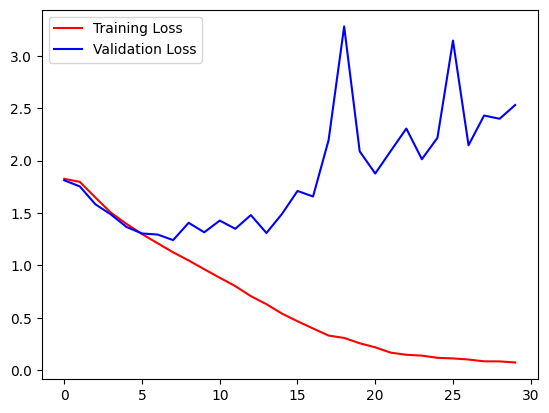

In [18]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [19]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


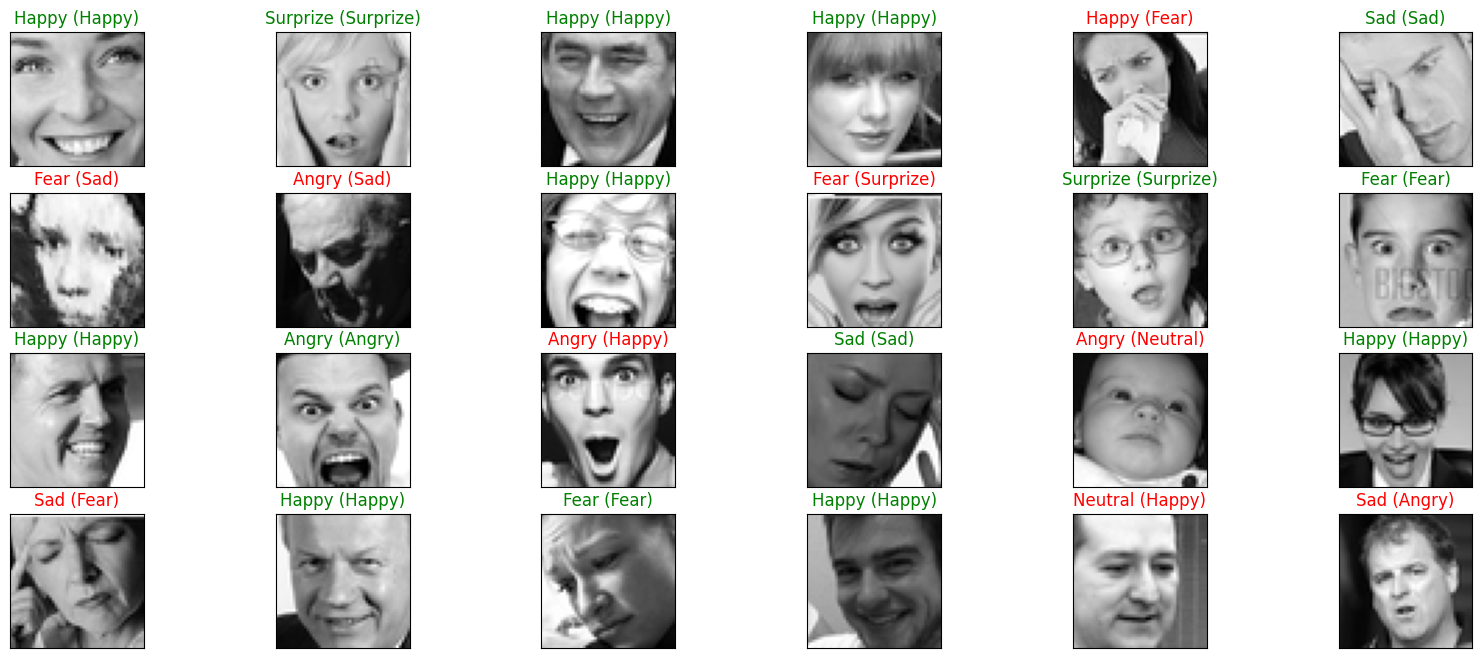

In [20]:
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]

      ax.set_title("{} ({})".format((predict_index),
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [21]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

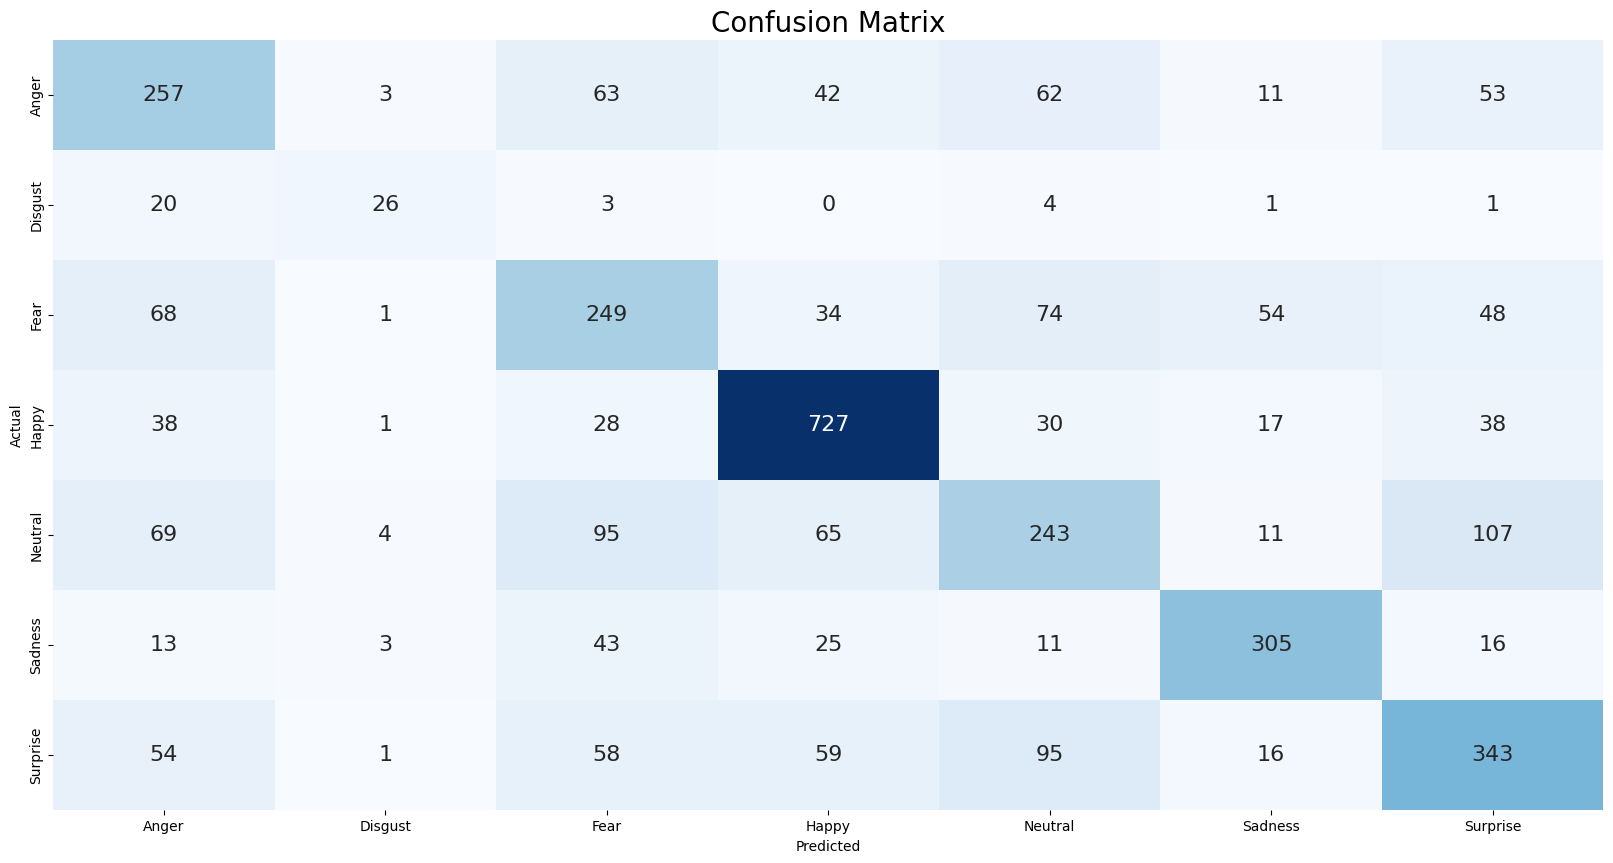

In [22]:
conf_mat(y_test,y_pred)

In [23]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.495     0.523     0.509       491
           1      0.667     0.473     0.553        55
           2      0.462     0.472     0.467       528
           3      0.764     0.827     0.794       879
           4      0.468     0.409     0.437       594
           5      0.735     0.733     0.734       416
           6      0.566     0.548     0.557       626

    accuracy                          0.599      3589
   macro avg      0.594     0.569     0.579      3589
weighted avg      0.594     0.599     0.596      3589



In [24]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9843 - loss: 0.0495
On Training Data [0.052060991525650024, 0.9826534986495972]
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6024 - loss: 2.3877
On Validation Data [2.3995118141174316, 0.5973808765411377]
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6053 - loss: 2.3485
On Test Data [2.3877999782562256, 0.5990526676177979]


#Fine Tuning
<hr>

Let's try to improve the model

##1. Changing epoch, learning rate and batch size

In [25]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=60,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2364 - loss: 1.8506
Epoch 1: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.2364 - loss: 1.8506 - val_accuracy: 0.2494 - val_loss: 1.8132
Epoch 2/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2549 - loss: 1.8161
Epoch 2: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.2549 - loss: 1.8161 - val_accuracy: 0.2494 - val_loss: 1.8001
Epoch 3/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2502 - loss: 1.8020
Epoch 3: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.2502 - loss: 1.8020 - val_accuracy: 0.3101 - val_loss: 1.7624
Epoch 4/60
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2920 - loss: 1.7523
Epoch 4: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.2921 - loss: 1.7523 - val_accuracy

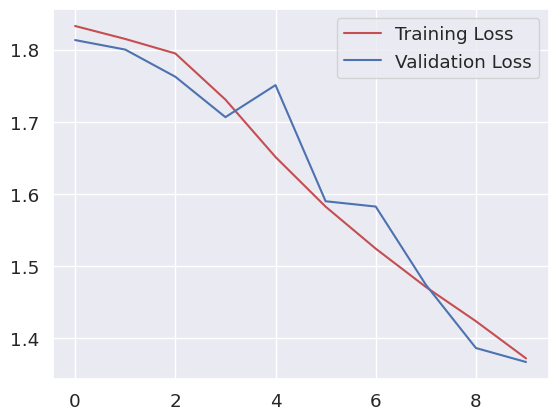

In [26]:
loss_plot(history)

In [27]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       491
           1      0.000     0.000     0.000        55
           2      0.000     0.000     0.000       528
           3      0.245     1.000     0.393       879
           4      0.000     0.000     0.000       594
           5      0.000     0.000     0.000       416
           6      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##2. Changing optimizer

In [28]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2500 - loss: 1.8128
Epoch 1: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 52s 97ms/step - accuracy: 0.2501 - loss: 1.8126 - val_accuracy: 0.3834 - val_loss: 1.5624
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4134 - loss: 1.4933
Epoch 2: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 73s 84ms/step - accuracy: 0.4135 - loss: 1.4931 - val_accuracy: 0.4461 - val_loss: 1.3838
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4947 - loss: 1.3057
Epoch 3: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.4947 - loss: 1.3056 - val_accuracy: 0.5174 - val_loss: 1.2575
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5486 - loss: 1.1705
Epoch 4: val_accuracy did not improve from 0.59738
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.5486 - loss: 1.1704 - val_accuracy

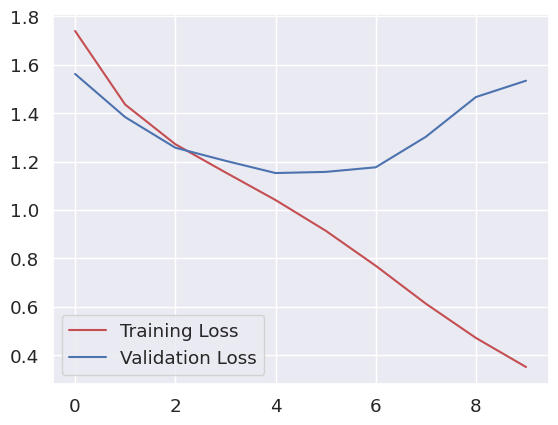

In [29]:
loss_plot(history)

In [30]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       491
           1      0.000     0.000     0.000        55
           2      0.000     0.000     0.000       528
           3      0.245     1.000     0.393       879
           4      0.000     0.000     0.000       594
           5      0.000     0.000     0.000       416
           6      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Observation

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#Model Saving

In [31]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#Deploying model using OpenCV
<hr>

Note: Run the below code in your local machine

##loading model arch and weights

In [34]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('best_model.keras')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 66 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##Open CV code for webcam and prediction

<IPython.core.display.Javascript object>

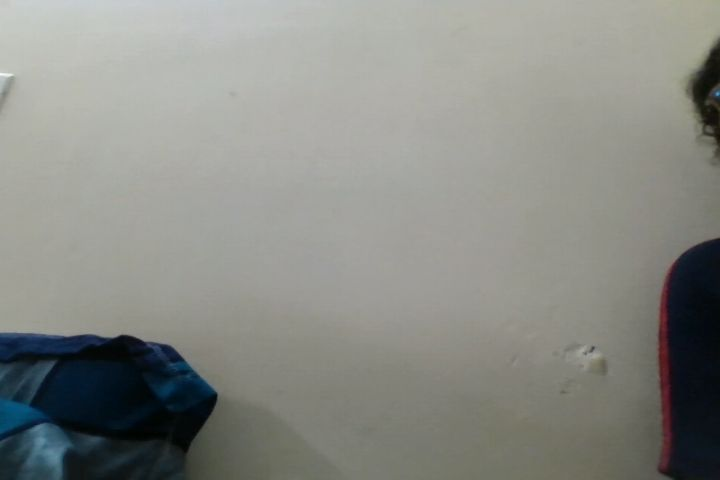

In [7]:
# cap=cv2.VideoCapture(0) # start webcam
# while True:
#     (valid,test_image)=cap.read() #reading image from video frame
#     if not valid: #if not getting frames then exit
#         break

#     gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


#     faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
#     for (x,y,w,h) in faces_detected: #cordinates of deteced faces
#         cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
#         roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
#         roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
#         image_pixels = img_to_array(roi_gray) #converting image to array
#         image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
#         # image_pixels /= 255


#         predictions = model.predict(image_pixels) #model prediction
#         max_index = np.argmax(predictions[0]) #getting emotion index

#         emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
#         emotion_prediction = emotion_detection[max_index]


#         cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
#     #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)


#         resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
#         cv2.imshow('Emotion Dectector',resize_image)
#         if cv2.waitKey(10) == ord('b'):
#             break
# cap.release()
# cv2.destroyAllWindows
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      video.width = 720;
      video.height = 480;

      const canvas = document.createElement('canvas');
      canvas.width = 720;
      canvas.height = 480;
      const context = canvas.getContext('2d');

      const data = await new Promise((resolve) => {
        capture.onclick = () => {
          context.drawImage(video, 0, 0, canvas.width, canvas.height);
          stream.getTracks().forEach(track => track.stop());
          div.remove();
          resolve(canvas.toDataURL('image/jpeg', quality));
        };
      });
      return data;
    }
    ''')
    display(js)

    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    img = cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)
    return img

# Run the function and display the captured photo
try:
    img = take_photo()
    cv2_imshow(img)  # Use cv2_imshow to display the image in Colab
except Exception as e:
    print("An error occurred:", e)


In [36]:

model.save('saved_model.h5')  # Save as a single HDF5 file


In [37]:
model.save('my_model.keras')  # Saves in the new format


In [38]:
from keras.models import load_model

model = load_model('my_model.keras')



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
